# CVADR Processing

**Author:** Laetitia Tam

**Last Modified**: 2020-03-06

In this notebook, files from the CVADR dataset are imported and merged. Preliminary data cleaning is performed. 

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', 1000)

## Contents

1. Import files
  1. Reports
  2. Report Drugs
  3. Drug Ingredients
  4. Reactions
2. Merge Dataframes
3. Limit to Active Ingredients in SIDER/DrugBank
4. Generate the Target Variable

## 1.a. Reports

This file contains the unique reports that are filed in the CVADRs database.

Import the file and keep only the relevant data columsn. 

Since the weight columns is dependent on the weight unit column, these are all converted to kilograms. 

After inspecting the age column, there were a small number of reports where age was higher than 122 years, which is the oldest reported age, so these were removed. (In general, there are were sufficient number of reports for modeling, so the approach to "dirty" data was to remove it.)

In [4]:
data_dir = '..\data\\'

In [5]:
# import data

reports = pd.read_csv(data_dir + 'CVADR/reports.txt',
                      delimiter='$',
                      header=None,
                      names=['REPORT_NO', 'E2B_IMP_SAFETYREPORT_ID', 'VERSION_NO', 'DATRECEIVED', 'DATINTRECEIVED', 'MAH_NO', 'REPORT_TYPE_CODE', 'REPORT_TYPE_ENG', 'REPORT_TYPE_FR', 'GENDER_CODE', 'GENDER_ENG', 'GENDER_FR', 'AGE', 'AGE_Y', 'AGE_UNIT_ENG', 'AGE_UNIT_FR', 'OUTCOME_CODE', 'OUTCOME_ENG', 'OUTCOME_FR', 'WEIGHT', 'WEIGHT_UNIT_ENG', 'WEIGHT_UNIT_FR',
                             'HEIGHT', 'HEIGHT_UNIT_ENG', 'HEIGHT_UNIT_FR', 'SERIOUSNESS_CODE', 'SERIOUSNESS_ENG', 'SERIOUSNESS_FR', 'DEATH', 'DISABILITY', 'CONGENITAL_ANOMALY', 'LIFE_THREATENING', 'HOSP_REQUIRED', 'OTHER_MEDICALLY_IMP_COND', 'REPORTER_TYPE_ENG', 'REPORTER_TYPE_FR', 'SOURCE_CODE', 'SOURCE_ENG', 'SOURCE_FR', 'UNKNOWN_1', 'UNKNOWN_2', 'UNKNOWN_3'],
                      dtype={'REPORT_NO': 'object', 'E2B_IMP_SAFETYREPORT_ID': 'object', 'VERSION_NO': 'int64', 'MAH_NO': 'object', 'REPORT_TYPE_CODE': 'category', 'REPORT_TYPE_ENG': 'category', 'REPORT_TYPE_FR': 'category', 'GENDER_CODE': 'category', 'GENDER_ENG': 'category', 'GENDER_FR': 'category', 'AGE': 'float64', 'AGE_Y': 'float64', 'AGE_UNIT_ENG': 'category', 'AGE_UNIT_FR': 'category', 'OUTCOME_CODE': 'category', 'OUTCOME_ENG': 'category', 'OUTCOME_FR': 'category', 'WEIGHT': 'float64', 'WEIGHT_UNIT_ENG': 'object', 'WEIGHT_UNIT_FR': 'object', 'HEIGHT': 'float64',
                             'HEIGHT_UNIT_ENG': 'object', 'HEIGHT_UNIT_FR': 'object', 'SERIOUSNESS_CODE': 'category', 'SERIOUSNESS_ENG': 'category', 'SERIOUSNESS_FR': 'category', 'DEATH': 'category', 'DISABILITY': 'category', 'CONGENITAL_ANOMALY': 'category', 'LIFE_THREATENING': 'category', 'HOSP_REQUIRED': 'category', 'OTHER_MEDICALLY_IMP_COND': 'category', 'REPORTER_TYPE_ENG': 'category', 'REPORTER_TYPE_FR': 'category', 'SOURCE_CODE': 'category', 'SOURCE_ENG': 'category', 'SOURCE_FR': 'category', 'UNKNOWN_1': 'object', 'UNKNOWN_2': 'object', 'UNKNOWN_3': 'object'},
                      parse_dates=['DATRECEIVED', 'DATINTRECEIVED'])

# remove unecessary columns

reports = reports[['REPORT_NO', 'DATRECEIVED', 'DATINTRECEIVED', 'MAH_NO',  'REPORT_TYPE_ENG', 'GENDER_ENG', 'AGE_Y', 'WEIGHT', 'WEIGHT_UNIT_ENG', 'SERIOUSNESS_ENG',  'DEATH', 'DISABILITY', 'CONGENITAL_ANOMALY', 'LIFE_THREATENING', 'HOSP_REQUIRED', 'OTHER_MEDICALLY_IMP_COND', 'REPORTER_TYPE_ENG',  'SOURCE_ENG']]

In [6]:
#Remove reports with ages over 122 years

reports_a = reports[reports.AGE_Y <= 122]

In [7]:
# Convert all weights to kilograms.
reports_a['WEIGHT_UNIT_ENG'].unique()

def fix_weight(row):
    if row['WEIGHT_UNIT_ENG']=='Kilogram':
        return row['WEIGHT']
    if row['WEIGHT_UNIT_ENG']=='Pound':
        return row['WEIGHT']*.454
    if row['WEIGHT_UNIT_ENG']=='Ounce':
        return row['WEIGHT']*0.0283495
    else:
        return np.NaN

reports_a['WEIGHT_KG'] = reports_a.apply(fix_weight, axis=1)

# reports_a.head()

C:\Users\lucwi\Desktop\Laetitia\WPy64-3760\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
reports_a[reports_a['WEIGHT_KG'].notnull()].head(2)

,REPORT_NO,DATRECEIVED,DATINTRECEIVED,MAH_NO,REPORT_TYPE_ENG,GENDER_ENG,AGE_Y,WEIGHT,WEIGHT_UNIT_ENG,SERIOUSNESS_ENG,DEATH,DISABILITY,CONGENITAL_ANOMALY,LIFE_THREATENING,HOSP_REQUIRED,OTHER_MEDICALLY_IMP_COND,REPORTER_TYPE_ENG,SOURCE_ENG,WEIGHT_KG
0,1,1973-06-05,1973-06-05,NaN,Spontaneous,Female,62.0,66.0,Kilogram,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0
2,3,1973-06-05,1973-06-05,NaN,Spontaneous,Male,83.0,44.0,Kilogram,Serious,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hospital,44.0


In [9]:
reports_b = reports_a[['REPORT_NO', 'DATRECEIVED', 'DATINTRECEIVED', 
       'REPORT_TYPE_ENG', 'GENDER_ENG', 'AGE_Y', 'SERIOUSNESS_ENG', 'DEATH', 'DISABILITY',
       'CONGENITAL_ANOMALY', 'LIFE_THREATENING', 'HOSP_REQUIRED',
       'OTHER_MEDICALLY_IMP_COND', 'REPORTER_TYPE_ENG', 'SOURCE_ENG',
       'WEIGHT_KG']]

In [10]:
# check row count
report_check = pd.concat([reports[['REPORT_NO', 'DATRECEIVED']].nunique(), reports_b[['REPORT_NO', 'DATRECEIVED']].nunique()], axis=1)
report_check.columns = ['Original','Processed']
report_check

,Original,Processed
REPORT_NO,751171,606230
DATRECEIVED,14090,13694


## 1.b. Report Drug

This file contains all the drugs and related charateristics that are linked to reports. Both "suspect" and "concomitant" drugs (other drugs that the person is using at the same time) are included.

In [11]:
report_drug = pd.read_csv(data_dir + 'CVADR/report_drug.txt', 
                      delimiter='$', 
                      header=None, 
                      names=['REPORT_DRUG_ID', 'REPORT_ID', 'DRUG_PRODUCT_ID', 'DRUGNAME', 'DRUGINVOLV_ENG', 'DRUGINVOLV_FR', 'ROUTEADMIN_ENG', 'ROUTEADMIN_FR', 'UNIT_DOSE_QTY', 'DOSE_UNIT_ENG', 'DOSE_UNIT_FR', 'FREQUENCY', 'FREQ_TIME', 'FREQUENCY_TIME_ENG', 'FREQUENCY_TIME_FR', 'FREQ_TIME_UNIT_ENG', 'FREQ_TIME_UNIT_FR', 'THERAPY_DURATION', 'THERAPY_DURATION_UNIT_ENG', 'THERAPY_DURATION_UNIT_FR', 'DOSAGEFORM_ENG', 'DOSAGEFORM_FR'],
                      dtype={'REPORT_DRUG_ID': 'object', 'REPORT_ID': 'object', 'DRUG_PRODUCT_ID': 'object', 'DRUGNAME': 'object', 'DRUGINVOLV_ENG': 'category', 'DRUGINVOLV_FR': 'category', 'ROUTEADMIN_ENG': 'object', 'ROUTEADMIN_FR': 'object', 'UNIT_DOSE_QTY': 'float64', 'DOSE_UNIT_ENG': 'object', 'DOSE_UNIT_FR': 'object', 'FREQUENCY': 'float64', 'FREQ_TIME': 'category', 'FREQUENCY_TIME_ENG': 'category', 'FREQUENCY_TIME_FR': 'category', 'FREQ_TIME_UNIT_ENG': 'object', 'FREQ_TIME_UNIT_FR': 'object', 'THERAPY_DURATION': 'float64', 'THERAPY_DURATION_UNIT_ENG': 'category', 'THERAPY_DURATION_UNIT_FR': 'category', 'DOSAGEFORM_ENG': 'object', 'DOSAGEFORM_FR': 'object'}
                     )


# remove unecessary columns:
# 'DRUGINVOLV_FR','ROUTEADMIN_FR', 'DOSE_UNIT_FR', 'FREQUENCY_TIME_FR','FREQ_TIME_UNIT_FR', 'THERAPY_DURATION_UNIT_FR', 'DOSAGEFORM_FR'
# 'UNIT_DOSE_QTY', 'DOSE_UNIT_ENG', 'FREQUENCY', 'FREQ_TIME', 'FREQUENCY_TIME_ENG',  'FREQ_TIME_UNIT_ENG', 'THERAPY_DURATION', 'THERAPY_DURATION_UNIT_ENG', 
# dosing varibles removed because it is hard to interpret and not comparable between reports

report_drug = report_drug[['REPORT_DRUG_ID', 'REPORT_ID', 'DRUG_PRODUCT_ID', 'DRUGNAME', 'DRUGINVOLV_ENG', 'ROUTEADMIN_ENG', 'DOSAGEFORM_ENG']]

In [12]:
# report_drug.head()
# report_drug.nunique()

Reports with more than one "suspect" drug are removed since it is not possible to tell which drug is responsible for the reaction. 

In [13]:
reports_by_involvement = report_drug.groupby(['REPORT_ID','DRUGINVOLV_ENG'])['REPORT_DRUG_ID'].count().reset_index()
reports_by_involvement.columns = ['REPORT_ID', 'INVOLVEMENT', 'INVOLVEMENT_COUNT']
suspect_count = reports_by_involvement[reports_by_involvement['INVOLVEMENT']=='Suspect']
report_drug_a = report_drug[report_drug['REPORT_ID'].isin(suspect_count[suspect_count['INVOLVEMENT_COUNT']==1]['REPORT_ID'])]
# report_drug_a.head()

Instead of including individual concomitant drugs as variables, the count of concomitant drugs is included.

In [14]:
concomitant_count = reports_by_involvement[reports_by_involvement['INVOLVEMENT']=='Concomitant']

report_drug_b = report_drug_a.merge(concomitant_count, how='left', on='REPORT_ID', copy=False)[['REPORT_DRUG_ID', 'REPORT_ID', 'DRUG_PRODUCT_ID', 'DRUGNAME',
       'DRUGINVOLV_ENG', 'ROUTEADMIN_ENG', 'DOSAGEFORM_ENG',
       'INVOLVEMENT_COUNT']]

report_drug_b = report_drug_b.rename(columns={'INVOLVEMENT_COUNT':'CONCOMITANT_DRUGS'})
report_drug_b['CONCOMITANT_DRUGS'] = report_drug_b['CONCOMITANT_DRUGS'].fillna(0)

# keep only the suspect observation 
report_drug_c = report_drug_b[report_drug_b['DRUGINVOLV_ENG']=='Suspect']

# report_drug_c.head()
# report_drug_c.nunique() 

In [15]:
# check row count
report_drug_check = pd.concat([report_drug[['REPORT_DRUG_ID', 'REPORT_ID', 'DRUG_PRODUCT_ID', 'DRUGNAME',
       'DRUGINVOLV_ENG']].nunique(), report_drug_c[['REPORT_DRUG_ID', 'REPORT_ID', 'DRUG_PRODUCT_ID', 'DRUGNAME',
       'DRUGINVOLV_ENG']].nunique()], axis=1)
report_drug_check.columns = ['Original','Processed']
report_drug_check

,Original,Processed
REPORT_DRUG_ID,2860848,528444
REPORT_ID,751107,528444
DRUG_PRODUCT_ID,44794,19867
DRUGNAME,34634,15293
DRUGINVOLV_ENG,5,1


## 1.c. Drug Ingredients

This file contains info the ingredients within each drug that is reported on.

In [16]:
# Import Data

drug_ingredients = pd.read_csv(data_dir + 'CVADR/drug_product_ingredients.txt', 
                            delimiter='$',
                            header = None,
                            names = ['DRUG_PRODUCT_INGREDIENT_ID','DRUG_PRODUCT_ID','DRUGNAME','ACTIVE_INGREDIENT_ID','ACTIVE_INGREDIENT_NAME'],
                            dtype = {'DRUG_PRODUCT_INGREDIENT_ID':'object', 'DRUG_PRODUCT_ID':'object','ACTIVE_INGREDIENT_ID':'object'})

In [17]:
drug_ingredients_a = drug_ingredients.drop_duplicates(['DRUG_PRODUCT_ID','ACTIVE_INGREDIENT_NAME'])

In [18]:
drug_ingredients_a.nunique()

DRUG_PRODUCT_INGREDIENT_ID    285405
DRUG_PRODUCT_ID                30847
DRUGNAME                       22690
ACTIVE_INGREDIENT_ID           18990
ACTIVE_INGREDIENT_NAME         17631
dtype: int64

##  1.d. Reactions

This file contains the reations (adverse event) associated with the report. Each report may contain multiple reactions. 

In [19]:
reactions = reactions = pd.read_csv(data_dir + 'CVADR/reactions.txt', 
                            delimiter='$',
                            header = None,
                            names = ['REACTION_ID','REPORT_ID','DURATION','DURATION_UNIT_ENG','DURATION_UNIT_FR','PT_NAME_ENG','PT_NAME_FR','SOC_NAME_ENG','SOC_NAME_FR','MEDDRA_VERSION'],
                            dtype = {'REACTION_ID':'object','REPORT_ID':'object', 'PT_NAME_ENG':'category', 'SOC_NAME_ENG':'category', 'MEDDRA_VERSION':'category' })


# remove unecessary columns
reactions = reactions[['REACTION_ID','REPORT_ID', 'PT_NAME_ENG','SOC_NAME_ENG']]

C:\Users\lucwi\Desktop\Laetitia\WPy64-3760\python-3.7.6.amd64\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
# remove duplcate reactions from each report

reactions_a = reactions.drop_duplicates(subset=['REPORT_ID','PT_NAME_ENG','SOC_NAME_ENG'])

Some reports have a large number of associated reactions (>100). This doesn't really make sense, so outliers (greater than 3 standard deviations from the mean) are removed. 

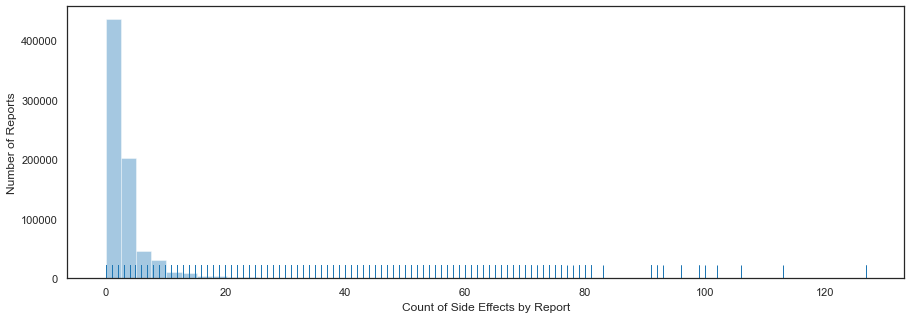

In [21]:
se_count_by_report = reactions_a.groupby('REPORT_ID')['PT_NAME_ENG','SOC_NAME_ENG'].count().sort_values(by='PT_NAME_ENG',ascending=True).reset_index()
se_count_by_report.tail(10)

sns.set_style("white")
sns.set_context('notebook')
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

ax = sns.distplot(se_count_by_report.PT_NAME_ENG, kde=False, rug=True)
ax.set_xlabel('Count of Side Effects by Report')
ax.set_ylabel('Number of Reports')

plt.show()

In [22]:
from numpy import mean
from numpy import std
se_mean = mean(se_count_by_report.PT_NAME_ENG)
se_std = std(se_count_by_report.PT_NAME_ENG)
max_se = se_mean+3*se_std
print('mean :' + str(se_mean) + '\nstdev: ' + str(se_std))
print('upper bound: ' + str(max_se))

mean :3.4202813013350957
stdev: 4.344247243360661
upper bound: 16.45302303141708


In [23]:
included_reports = se_count_by_report[se_count_by_report.PT_NAME_ENG <= max_se]

In [24]:
reactions_a = reactions_a[reactions_a['REPORT_ID'].isin(included_reports['REPORT_ID'])]

In [25]:
# check row count
reactions_check = pd.concat([reactions[['REPORT_ID', 'PT_NAME_ENG']].nunique(), reactions_a[['REPORT_ID', 'PT_NAME_ENG']].nunique()], axis=1)
reactions_check.columns = ['Original','Processed']
reactions_check

,Original,Processed
REPORT_ID,750583,735833
PT_NAME_ENG,11993,11518


# 2. Merge Dataframes

Merge dataframes from eac file together. 


In [26]:
merge_a = reports_b.merge(report_drug_c, how='left', left_on='REPORT_NO', right_on='REPORT_ID' , validate='one_to_many', copy=False)
merge_a.head()

,REPORT_NO,DATRECEIVED,DATINTRECEIVED,REPORT_TYPE_ENG,GENDER_ENG,AGE_Y,SERIOUSNESS_ENG,DEATH,DISABILITY,CONGENITAL_ANOMALY,LIFE_THREATENING,HOSP_REQUIRED,OTHER_MEDICALLY_IMP_COND,REPORTER_TYPE_ENG,SOURCE_ENG,WEIGHT_KG,REPORT_DRUG_ID,REPORT_ID,DRUG_PRODUCT_ID,DRUGNAME,DRUGINVOLV_ENG,ROUTEADMIN_ENG,DOSAGEFORM_ENG,CONCOMITANT_DRUGS
0,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0
1,2,1973-06-05,1973-06-05,Spontaneous,Female,70.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hospital,NaN,28,2,18594,PENBRITIN,Suspect,Oral,NOT SPECIFIED,0.0
2,3,1973-06-05,1973-06-05,Spontaneous,Male,83.0,Serious,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hospital,44.0,29,3,1318,NEOSPORIN OINTMENT,Suspect,Ophthalmic,OINTMENT TOPICAL,0.0
3,4,1973-06-05,1973-06-05,Spontaneous,Female,78.0,Serious,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hospital,NaN,30,4,18620,TETRACYCLINE,Suspect,Oral,NOT SPECIFIED,0.0
4,5,1973-06-05,1973-06-05,Spontaneous,Female,55.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Community,NaN,31,5,18851,INH,Suspect,Oral,NOT SPECIFIED,0.0


In [27]:
merge_b = merge_a.merge(drug_ingredients_a, how='left', on='DRUG_PRODUCT_ID', copy=False)
merge_b.head()

,REPORT_NO,DATRECEIVED,DATINTRECEIVED,REPORT_TYPE_ENG,GENDER_ENG,AGE_Y,SERIOUSNESS_ENG,DEATH,DISABILITY,CONGENITAL_ANOMALY,LIFE_THREATENING,HOSP_REQUIRED,OTHER_MEDICALLY_IMP_COND,REPORTER_TYPE_ENG,SOURCE_ENG,WEIGHT_KG,REPORT_DRUG_ID,REPORT_ID,DRUG_PRODUCT_ID,DRUGNAME_x,DRUGINVOLV_ENG,ROUTEADMIN_ENG,DOSAGEFORM_ENG,CONCOMITANT_DRUGS,DRUG_PRODUCT_INGREDIENT_ID,DRUGNAME_y,ACTIVE_INGREDIENT_ID,ACTIVE_INGREDIENT_NAME
0,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708178,GANTRISIN,8178,sulfisoxazole
1,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708179,GANTRISIN,8179,sulfafurazole
2,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886706008177,GANTRISIN,6008177,sulfisoxazole sodium
3,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886706008148,GANTRISIN,6008148,sulfafurazole diethanolamine
4,2,1973-06-05,1973-06-05,Spontaneous,Female,70.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hospital,NaN,28,2,18594,PENBRITIN,Suspect,Oral,NOT SPECIFIED,0.0,1859408450,PENBRITIN,8450,ampicillin


In [28]:
merge_c = merge_b.merge(reactions_a, how='left', on='REPORT_ID', copy=False)
merge_c.head()

,REPORT_NO,DATRECEIVED,DATINTRECEIVED,REPORT_TYPE_ENG,GENDER_ENG,AGE_Y,SERIOUSNESS_ENG,DEATH,DISABILITY,CONGENITAL_ANOMALY,LIFE_THREATENING,HOSP_REQUIRED,OTHER_MEDICALLY_IMP_COND,REPORTER_TYPE_ENG,SOURCE_ENG,WEIGHT_KG,REPORT_DRUG_ID,REPORT_ID,DRUG_PRODUCT_ID,DRUGNAME_x,DRUGINVOLV_ENG,ROUTEADMIN_ENG,DOSAGEFORM_ENG,CONCOMITANT_DRUGS,DRUG_PRODUCT_INGREDIENT_ID,DRUGNAME_y,ACTIVE_INGREDIENT_ID,ACTIVE_INGREDIENT_NAME,REACTION_ID,PT_NAME_ENG,SOC_NAME_ENG
0,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708178,GANTRISIN,8178,sulfisoxazole,102,Pruritus,Skin and subcutaneous tissue disorders
1,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708178,GANTRISIN,8178,sulfisoxazole,101,Oedema,General disorders and administration site cond...
2,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708179,GANTRISIN,8179,sulfafurazole,102,Pruritus,Skin and subcutaneous tissue disorders
3,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708179,GANTRISIN,8179,sulfafurazole,101,Oedema,General disorders and administration site cond...
4,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886706008177,GANTRISIN,6008177,sulfisoxazole sodium,102,Pruritus,Skin and subcutaneous tissue disorders


In [29]:
# check the file size
merge_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5414154 entries, 0 to 5414153
Data columns (total 31 columns):
REPORT_NO                     object
DATRECEIVED                   datetime64[ns]
DATINTRECEIVED                datetime64[ns]
REPORT_TYPE_ENG               category
GENDER_ENG                    category
AGE_Y                         float64
SERIOUSNESS_ENG               category
DEATH                         category
DISABILITY                    category
CONGENITAL_ANOMALY            category
LIFE_THREATENING              category
HOSP_REQUIRED                 category
OTHER_MEDICALLY_IMP_COND      category
REPORTER_TYPE_ENG             category
SOURCE_ENG                    category
WEIGHT_KG                     float64
REPORT_DRUG_ID                object
REPORT_ID                     object
DRUG_PRODUCT_ID               object
DRUGNAME_x                    object
DRUGINVOLV_ENG                category
ROUTEADMIN_ENG                object
DOSAGEFORM_ENG                o

In [30]:
merge_c.nunique()

REPORT_NO                      606230
DATRECEIVED                     13694
DATINTRECEIVED                  13670
REPORT_TYPE_ENG                     7
GENDER_ENG                          2
AGE_Y                             861
SERIOUSNESS_ENG                     2
DEATH                               2
DISABILITY                          2
CONGENITAL_ANOMALY                  2
LIFE_THREATENING                    2
HOSP_REQUIRED                       2
OTHER_MEDICALLY_IMP_COND            2
REPORTER_TYPE_ENG                   6
SOURCE_ENG                          5
WEIGHT_KG                        4145
REPORT_DRUG_ID                 418434
REPORT_ID                      418434
DRUG_PRODUCT_ID                 18056
DRUGNAME_x                      13827
DRUGINVOLV_ENG                      1
ROUTEADMIN_ENG                     69
DOSAGEFORM_ENG                    231
CONCOMITANT_DRUGS                  66
DRUG_PRODUCT_INGREDIENT_ID     134542
DRUGNAME_y                      12951
ACTIVE_INGRE

## 3. Limit to Active Ingredients and Reactions in SIDER/DrugBank

The CVADR data will need to be linked to the SIDER and DrugBank databases. Unfortunately, CVADR does not contain a linkable identifier like a DIN, so the linkage will rely on text matching. 

First, load SIDER and DrugBank datasets. 

In [31]:
# load SIDER 

sider = pd.read_csv(data_dir + 'sider/meddra_all_se.tsv', delimiter='\t', header=None,
                    names=['STITCH_FLAT','STITCH_STEREO', 'UMLS_CONCEPT_ID_LABEL','MEDDRA_CONCEPT_TYPE','UMLS_CONCEPT_ID_MEDDDRA','SE'],
                    usecols=[0,5])


# load DrugBank
# DrugBank contains a drugs file that has the preferred drug name as well as a synonyms file that contains alternatives. Load both for matching.

db_synonyms = pd.read_csv(data_dir + 'DrugBank/db/drug_syn.csv')
db_drugs = pd.read_csv(data_dir + 'DrugBank/db/drugs.csv', usecols=['primary_key','name'])

In [32]:
sider.head(2)

,STITCH_FLAT,SE
0,CID100000085,Abdominal cramps
1,CID100000085,Abdominal pain


In [33]:
db_synonyms.head(2)

,parent_key,synonym,language,coder
0,DB00001,Hirudin variant-1,english,NaN
1,DB00001,Lepirudin recombinant,english,NaN


In [34]:
db_drugs.head(2)

,primary_key,name
0,DB00001,Lepirudin
1,DB00002,Cetuximab


In [35]:
# filter for active ingrdients in DrugBank using names and synonyms
# There is room to improve drug name matching here. Could potentially try fuzzy matching in a future iteration. 

filter_a = merge_c[(merge_c['ACTIVE_INGREDIENT_NAME'].str.upper().isin(db_synonyms['synonym'].str.upper())) | 
                    (merge_c['ACTIVE_INGREDIENT_NAME'].str.upper().isin(db_drugs['name'].str.upper()))]

In [36]:
##  filter for Preferred MedDRA side effect terms using SIDER
filter_b = filter_a[filter_a['PT_NAME_ENG'].str.upper().isin(sider['SE'].str.upper())]

In [37]:
# check row count
filter_check = pd.concat([merge_c.nunique(), filter_a.nunique(), filter_b.nunique()], axis=1)
filter_check.columns = ['Original','Filter_a', 'Filter_b']
filter_check

,Original,Filter_a,Filter_b
REPORT_NO,606230,359331,338936
DATRECEIVED,13694,13082,13039
DATINTRECEIVED,13670,13073,13032
REPORT_TYPE_ENG,7,7,7
GENDER_ENG,2,2,2
AGE_Y,861,600,575
SERIOUSNESS_ENG,2,2,2
DEATH,2,2,2
DISABILITY,2,2,2
CONGENITAL_ANOMALY,2,2,2


In [38]:
filter_b.head()

,REPORT_NO,DATRECEIVED,DATINTRECEIVED,REPORT_TYPE_ENG,GENDER_ENG,AGE_Y,SERIOUSNESS_ENG,DEATH,DISABILITY,CONGENITAL_ANOMALY,LIFE_THREATENING,HOSP_REQUIRED,OTHER_MEDICALLY_IMP_COND,REPORTER_TYPE_ENG,SOURCE_ENG,WEIGHT_KG,REPORT_DRUG_ID,REPORT_ID,DRUG_PRODUCT_ID,DRUGNAME_x,DRUGINVOLV_ENG,ROUTEADMIN_ENG,DOSAGEFORM_ENG,CONCOMITANT_DRUGS,DRUG_PRODUCT_INGREDIENT_ID,DRUGNAME_y,ACTIVE_INGREDIENT_ID,ACTIVE_INGREDIENT_NAME,REACTION_ID,PT_NAME_ENG,SOC_NAME_ENG
0,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708178,GANTRISIN,8178,sulfisoxazole,102,Pruritus,Skin and subcutaneous tissue disorders
1,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708178,GANTRISIN,8178,sulfisoxazole,101,Oedema,General disorders and administration site cond...
2,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708179,GANTRISIN,8179,sulfafurazole,102,Pruritus,Skin and subcutaneous tissue disorders
3,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708179,GANTRISIN,8179,sulfafurazole,101,Oedema,General disorders and administration site cond...
8,2,1973-06-05,1973-06-05,Spontaneous,Female,70.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hospital,NaN,28,2,18594,PENBRITIN,Suspect,Oral,NOT SPECIFIED,0.0,1859408450,PENBRITIN,8450,ampicillin,201,Urticaria,Skin and subcutaneous tissue disorders


## 4. Generate the Target Variable

Since the goal is to predict whether the "true signals" as defined by the SIDER database, we need to create a column that indicates whether the reported reaction is a true signal or not. 

In [39]:
# Add a new binary column that indicates whether the listed side effect is in SIDER or not
# This will be the outcome variable

sider_pos = pd.read_csv(data_dir + 'sider_positives.csv')
sider_pos = sider_pos[['DRUG','ATC','SE', 'UMLS_CONCEPT_ID_MEDDDRA']]
sider_pos.head(5)


,DRUG,ATC,SE,UMLS_CONCEPT_ID_MEDDDRA
0,carnitine,A16AA01,Abdominal cramps,C0000729
1,carnitine,A16AA01,Abdominal pain,C0000737
2,carnitine,A16AA01,Abdominal pain,C0000737
3,carnitine,A16AA01,Gastrointestinal pain,C0687713
4,carnitine,A16AA01,Abdominal pain,C0000737


In [40]:
df = filter_b.copy()

# Merge the SIDER reactions onto the CVADR dataframe. If there is a drug with the same name and reaction, 
# the SIDER reaction name will be pulled in. If not, it will be NaN.
df_1 = df.merge(sider_pos, how='left', left_on=['ACTIVE_INGREDIENT_NAME','PT_NAME_ENG'], right_on=['DRUG','SE'])
df_1.head()

,REPORT_NO,DATRECEIVED,DATINTRECEIVED,REPORT_TYPE_ENG,GENDER_ENG,AGE_Y,SERIOUSNESS_ENG,DEATH,DISABILITY,CONGENITAL_ANOMALY,LIFE_THREATENING,HOSP_REQUIRED,OTHER_MEDICALLY_IMP_COND,REPORTER_TYPE_ENG,SOURCE_ENG,WEIGHT_KG,REPORT_DRUG_ID,REPORT_ID,DRUG_PRODUCT_ID,DRUGNAME_x,DRUGINVOLV_ENG,ROUTEADMIN_ENG,DOSAGEFORM_ENG,CONCOMITANT_DRUGS,DRUG_PRODUCT_INGREDIENT_ID,DRUGNAME_y,ACTIVE_INGREDIENT_ID,ACTIVE_INGREDIENT_NAME,REACTION_ID,PT_NAME_ENG,SOC_NAME_ENG,DRUG,ATC,SE,UMLS_CONCEPT_ID_MEDDDRA
0,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708178,GANTRISIN,8178,sulfisoxazole,102,Pruritus,Skin and subcutaneous tissue disorders,NaN,NaN,NaN,NaN
1,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708178,GANTRISIN,8178,sulfisoxazole,101,Oedema,General disorders and administration site cond...,NaN,NaN,NaN,NaN
2,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708179,GANTRISIN,8179,sulfafurazole,102,Pruritus,Skin and subcutaneous tissue disorders,NaN,NaN,NaN,NaN
3,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708179,GANTRISIN,8179,sulfafurazole,101,Oedema,General disorders and administration site cond...,NaN,NaN,NaN,NaN
4,2,1973-06-05,1973-06-05,Spontaneous,Female,70.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hospital,NaN,28,2,18594,PENBRITIN,Suspect,Oral,NOT SPECIFIED,0.0,1859408450,PENBRITIN,8450,ampicillin,201,Urticaria,Skin and subcutaneous tissue disorders,NaN,NaN,NaN,NaN


In [41]:
# Create the target variable column. Where there is a match in SIDER, set as True, else set as False. 
df_1['POSITIVE'] = False

In [42]:
df_1['POSITIVE'][df_1['UMLS_CONCEPT_ID_MEDDDRA'].notna()] = True

C:\Users\lucwi\Desktop\Laetitia\WPy64-3760\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
# Check the outcome.
df_1.groupby('POSITIVE').REPORT_NO.count().sort_values(ascending=False)

POSITIVE
False    1166426
True      849377
Name: REPORT_NO, dtype: int64

In [44]:
df_1 = df_1[['REPORT_NO', 'DATRECEIVED', 'DATINTRECEIVED', 'REPORT_TYPE_ENG',
       'GENDER_ENG', 'AGE_Y', 'SERIOUSNESS_ENG', 'DEATH', 'DISABILITY',
       'CONGENITAL_ANOMALY', 'LIFE_THREATENING', 'HOSP_REQUIRED',
       'OTHER_MEDICALLY_IMP_COND', 'REPORTER_TYPE_ENG', 'SOURCE_ENG',
       'WEIGHT_KG', 'REPORT_DRUG_ID', 'REPORT_ID', 'DRUG_PRODUCT_ID',
       'DRUGNAME_x', 'DRUGINVOLV_ENG', 'ROUTEADMIN_ENG', 'DOSAGEFORM_ENG',
       'CONCOMITANT_DRUGS', 'DRUG_PRODUCT_INGREDIENT_ID', 'DRUGNAME_y',
       'ACTIVE_INGREDIENT_ID', 'ACTIVE_INGREDIENT_NAME', 'REACTION_ID',
       'PT_NAME_ENG', 'SOC_NAME_ENG', 'POSITIVE']].reset_index()

In [45]:
df_1.head(1)

,index,REPORT_NO,DATRECEIVED,DATINTRECEIVED,REPORT_TYPE_ENG,GENDER_ENG,AGE_Y,SERIOUSNESS_ENG,DEATH,DISABILITY,CONGENITAL_ANOMALY,LIFE_THREATENING,HOSP_REQUIRED,OTHER_MEDICALLY_IMP_COND,REPORTER_TYPE_ENG,SOURCE_ENG,WEIGHT_KG,REPORT_DRUG_ID,REPORT_ID,DRUG_PRODUCT_ID,DRUGNAME_x,DRUGINVOLV_ENG,ROUTEADMIN_ENG,DOSAGEFORM_ENG,CONCOMITANT_DRUGS,DRUG_PRODUCT_INGREDIENT_ID,DRUGNAME_y,ACTIVE_INGREDIENT_ID,ACTIVE_INGREDIENT_NAME,REACTION_ID,PT_NAME_ENG,SOC_NAME_ENG,POSITIVE
0,0,1,1973-06-05,1973-06-05,Spontaneous,Female,62.0,Not Serious,NaN,NaN,NaN,NaN,NaN,NaN,Physician,NaN,66.0,27,1,18867,GANTRISIN,Suspect,Oral,Tablets,0.0,1886708178,GANTRISIN,8178,sulfisoxazole,102,Pruritus,Skin and subcutaneous tissue disorders,False


In [46]:
# export for next steps in Final_Dataset.ipynb

df_1.to_parquet(data_dir + 'df_1.parquet')